<a href="https://colab.research.google.com/github/NARAEIM/tp2-da/blob/jennlee/sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# library & dataset 불러오기

In [8]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

plt.style.use("default")

sales = pd.read_csv('/content/drive/MyDrive/co_note/project/data/sales.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
session_splt = pd.read_csv('/content/drive/MyDrive/co_note/project/data/buy_split.csv')
session_splt.head()

In [3]:
session_splt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12463004 entries, 0 to 12463003
Data columns (total 14 columns):
 #   Column           Dtype  
---  ------           -----  
 0   session_id       object 
 1   event_name       object 
 2   event_time       object 
 3   traffic_source   object 
 4   product_id       float64
 5   quantity         int64  
 6   item_price       int64  
 7   payment_status   float64
 8   search_keywords  object 
 9   promo_code       float64
 10  promo_amount     int64  
 11  customer_id      float64
 12  booking_id       object 
 13  quarter          float64
dtypes: float64(5), int64(3), object(6)
memory usage: 1.3+ GB


In [4]:
session_splt.session_id.nunique()

9318705

In [5]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 852582 entries, 0 to 852581
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   customer_id      852582 non-null  int64 
 1   booking_id       852582 non-null  object
 2   created_at       852582 non-null  object
 3   total_amount     852582 non-null  int64 
 4   promo_amount     852582 non-null  int64 
 5   shipment_fee     852582 non-null  int64 
 6   sales            852582 non-null  int64 
 7   gender           852582 non-null  object
 8   age_now          852582 non-null  int64 
 9   first_join_date  852582 non-null  object
dtypes: int64(6), object(4)
memory usage: 65.0+ MB


# sales dataset 생성

In [6]:
transaction = pd.read_csv('/content/drive/MyDrive/co_note/project/data/transaction_final.csv')
customer = pd.read_csv('/content/drive/MyDrive/co_note/project/data/customer_final.csv')

In [7]:
# Sort the transaction dataframe by customer_id and created_at
transaction.sort_values(by=['customer_id', 'created_at'], inplace=True)

# Calculate the 'sales' column
sales = pd.DataFrame(transaction.groupby(['customer_id', 'booking_id']).total_amount.unique() - transaction.groupby(['customer_id', 'booking_id']).shipment_fee.unique())

# Reset index to get 'customer_id' and 'booking_id' as columns
sales = sales.reset_index()

# Merge with the original transaction dataframe to include additional columns
sales = pd.merge(sales, transaction[['customer_id', 'booking_id', 'created_at', 'total_amount', 'promo_amount', 'with_promo', 'shipment_fee']], on=['customer_id', 'booking_id'], how='left')

# Display the resulting dataset
sales.head()

,customer_id,booking_id,0,created_at,total_amount,promo_amount,with_promo,shipment_fee
0,3,0b3f17a4-f733-4eac-b9e9-37c039746e95,[174717],2020-05-31 05:45:52.844494+00:00,174717,3791,1,0
1,3,0fb5a9e6-f306-4c37-b7f0-992bc78064a7,[189939],2022-06-26 15:41:52.844494+00:00,189939,4240,1,0
2,3,1229bd35-7747-447a-a60b-02860bf7da7e,[287523],2021-07-25 10:24:57.844494+00:00,287523,0,0,0
3,3,163e447d-f2c2-4fac-b8a1-015eb01afd41,[359032],2020-06-28 06:31:43.844494+00:00,359032,1472,1,0
4,3,182774df-3cde-46cf-b302-4d93e0d94288,[200436],2021-01-10 07:56:16.844494+00:00,205436,4746,1,5000


In [8]:
# Merge with the original transaction dataframe to include additional columns
sales = pd.merge(sales, customer[['customer_id', 'gender', 'age_now', 'first_join_date']], on=['customer_id'], how='left')

In [9]:
sales.drop_duplicates(subset='booking_id', inplace=True)

In [ ]:
sales.head()

In [ ]:
sales.shape

In [ ]:
sales.booking_id.duplicated().sum()

In [ ]:
1254578-401996

In [10]:
# promo amount는 ttl_amnt에서 이미 빠져있는 상태
sales['sales'] = sales['total_amount'] - sales['shipment_fee']

In [ ]:
sales.drop(axis=0, index=None, columns='0', inplace=True, errors='raise')

In [ ]:
sales.info()

In [ ]:
# sale dataset 저장
file_path = '/content/drive/MyDrive/co_note/project/data/sales.csv'
sales.to_csv(file_path, index=False)

# sales 전처리

In [11]:
sales['w_promo'] = (sales['promo_amount'] != 0).astype(int)

In [ ]:
display(sales.head(), sales.info())

In [13]:
sales['created_at'] = pd.to_datetime(sales['created_at'])
sales['y_m'] = sales['created_at'].dt.to_period('M')

<ipython-input-13-3c8275dc2cd7>:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  sales['y_m'] = sales['created_at'].dt.to_period('M')


In [ ]:
sales[sales['y_m'] == '2016-06']['customer_id'].nunique()

In [ ]:
sales.info()

# promotion

In [14]:
# promotion count
promo_cnt = sales.groupby(['y_m'])['w_promo'].sum().reset_index()
promo_cnt

,y_m,w_promo
0,2016-06,0
1,2016-07,184
2,2016-08,263
3,2016-09,336
4,2016-10,429
...,...,...
69,2022-03,9332
70,2022-04,9507
71,2022-05,9746
72,2022-06,8909


In [ ]:
sales_cnt = sales.groupby(['y_m'])['w_promo'].count().reset_index()
sales_cnt

In [ ]:
merge_promo = promo_cnt.merge(sales_cnt, on='y_m')
merge_promo.head()

In [ ]:
merge_promo.rename(columns = {'w_promo_x':'w_promo'}, inplace=True)
merge_promo.rename(columns = {'w_promo_y':'total_cnt'}, inplace=True)

In [ ]:
merge_promo.info()

In [ ]:
merge_promo['promo_usage'] = merge_promo['w_promo'] / merge_promo['total_cnt']
merge_promo.head()

In [ ]:
from scipy.signal import find_peaks

x = merge_promo['y_m'].astype(str)
y = merge_promo['promo_usage']

fig, ax = plt.subplots(figsize=(20, 8))
plt.plot(x, y)
plt.xlabel('Year-Month')
plt.ylabel('Promo Usage Ratio')
plt.title('Promo Usage')

# Peak detection
peaks, _ = find_peaks(y, distance=5)  # Adjust the 'distance' parameter as needed for peak detection

# Add vertical lines at detected peaks
for peak in peaks:
    plt.axvline(x=peak, color='red', linestyle='--')

plt.xticks(rotation=90)
plt.show()

# sales 분석

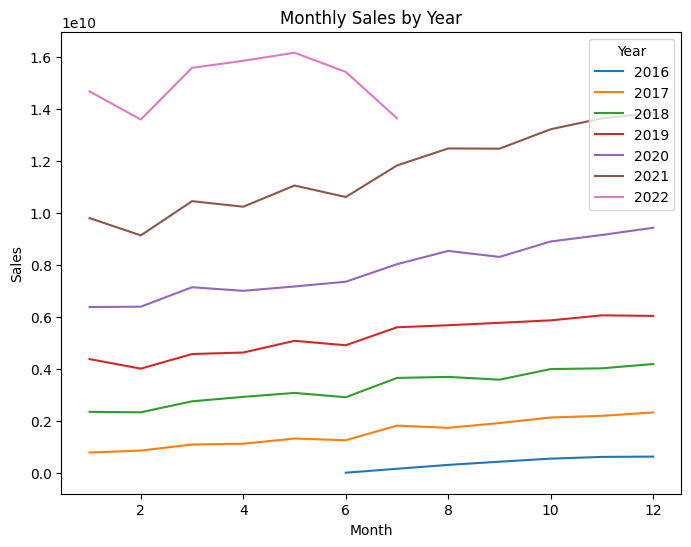

In [15]:
sales['year'] = sales['y_m'].dt.year
sales['month'] = sales['y_m'].dt.month

monthly_sales = sales.groupby(['year', 'month'])['sales'].sum().reset_index()

years = monthly_sales['year'].unique()

fig, ax = plt.subplots(figsize=(8, 6))

for year in years:
    year_data = monthly_sales[monthly_sales['year'] == year]
    ax.plot(year_data['month'], year_data['sales'], label=str(year))

ax.set_xlabel('Month')
ax.set_ylabel('Sales')
ax.set_title('Monthly Sales by Year')
ax.legend(title='Year')
plt.show()

In [16]:
monthly_sales['month'] = monthly_sales['month'].apply(lambda x: str(x).zfill(2))

# Create 'y_m' column using 'year' and 'month'
monthly_sales['y_m'] = monthly_sales['year'].astype(str) + '-' + monthly_sales['month'].astype(str)

monthly_sales

,year,month,sales,y_m
0,2016,06,630795,2016-06
1,2016,07,153024991,2016-07
2,2016,08,301940391,2016-08
3,2016,09,425768443,2016-09
4,2016,10,542623016,2016-10
...,...,...,...,...
69,2022,03,15596522404,2022-03
70,2022,04,15868079278,2022-04
71,2022,05,16178373393,2022-05
72,2022,06,15438986035,2022-06


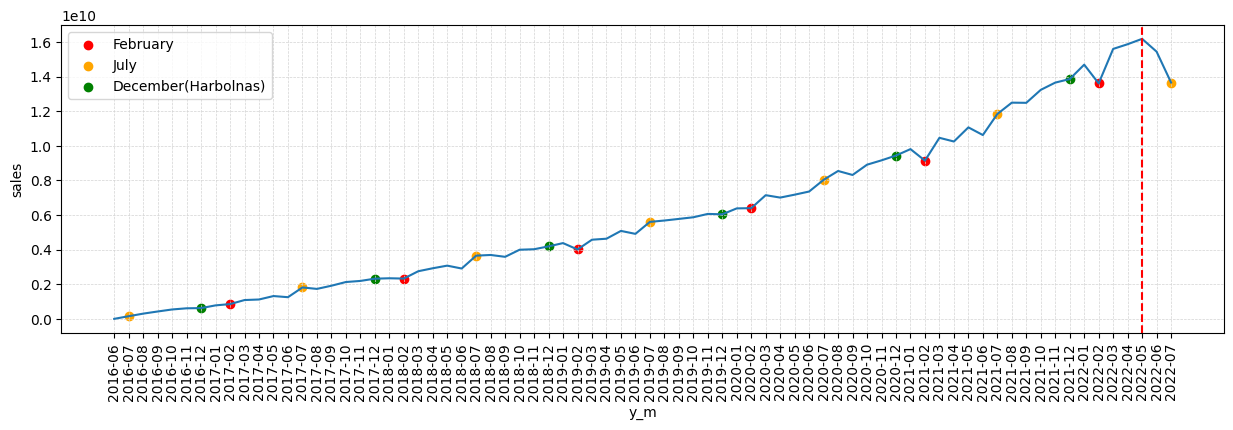

In [17]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(15, 4))
sns.lineplot(data=monthly_sales, x='y_m', y='sales', ax=ax)

plt.grid(color='lightgray', linestyle='--', linewidth=0.5)

sharp_points = ['2022-05']
for point in sharp_points:
    plt.axvline(x=point, color='red', linestyle='--')

# Mark each feb point with a marker
feb_points = monthly_sales[monthly_sales['y_m'].str.endswith('-02')]
plt.scatter(feb_points['y_m'], feb_points['sales'], marker='o', color='red', label='February')

# Mark each July point with a marker
july_points = monthly_sales[monthly_sales['y_m'].str.endswith('-07')]
plt.scatter(july_points['y_m'], july_points['sales'], marker='o', color='orange', label='July')

# Mark each December point with a marker
dec_points = monthly_sales[monthly_sales['y_m'].str.endswith('-12')]
plt.scatter(dec_points['y_m'], dec_points['sales'], marker='o', color='green', label='December(Harbolnas)')

plt.legend()

plt.xticks(rotation=90)
plt.show()

In [18]:
def plot_visitors(df):
  #index의 month를 x축으로 선택
  month = df.index.get_level_values('month').astype(str)

  # 방문객 수 데이터
  visitors = df[df.columns[0]]

  # 시계열 그래프 그리기
  plt.figure(figsize=(20, 6))
  plt.plot(month, visitors)
  plt.xlabel('Month')
  plt.ylabel('Visitors')
  plt.title(f'MONTHLY "{df.columns[0]}" PAGE VISITORS')
  plt.xticks(rotation=45)  # x축 라벨 회전
  return plt.show()

#객단가


## 월별 매출

In [19]:
monthly_sales = sales.groupby(sales['y_m'])['sales'].sum()
monthly_sales

y_m
2016-06         630795
2016-07      153024991
2016-08      301940391
2016-09      425768443
2016-10      542623016
              ...     
2022-03    15596522404
2022-04    15868079278
2022-05    16178373393
2022-06    15438986035
2022-07    13655487398
Freq: M, Name: sales, Length: 74, dtype: int64

In [20]:
monthly_sales_df = monthly_sales.to_frame(name='sales').reset_index()
monthly_sales_df

,y_m,sales
0,2016-06,630795
1,2016-07,153024991
2,2016-08,301940391
3,2016-09,425768443
4,2016-10,542623016
...,...,...
69,2022-03,15596522404
70,2022-04,15868079278
71,2022-05,16178373393
72,2022-06,15438986035


## 월별 unique 구매 session 수

In [21]:
# 구매한 경우: event_name == 'booking'
monthly_buy = session_splt[session_splt.event_name == 'BOOKING']
monthly_buy.shape

(852582, 14)

In [22]:
monthly_buy['event_time'] = pd.to_datetime(monthly_buy['event_time'])
monthly_buy_cnt = monthly_buy.groupby(monthly_buy['event_time'].dt.to_period('M'))['session_id'].nunique()
monthly_buy_cnt

<ipython-input-22-cd5dfac13239>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_buy['event_time'] = pd.to_datetime(monthly_buy['event_time'])
<ipython-input-22-cd5dfac13239>:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly_buy_cnt = monthly_buy.groupby(monthly_buy['event_time'].dt.to_period('M'))['session_id'].nunique()


event_time
2016-06        1
2016-07      296
2016-08      547
2016-09      717
2016-10      989
           ...  
2022-03    28801
2022-04    29237
2022-05    30084
2022-06    28587
2022-07    25162
Freq: M, Name: session_id, Length: 74, dtype: int64

In [23]:
monthly_buy_cnt_df = monthly_buy_cnt.to_frame(name='buy_cnt').reset_index()
monthly_buy_cnt_df

,event_time,buy_cnt
0,2016-06,1
1,2016-07,296
2,2016-08,547
3,2016-09,717
4,2016-10,989
...,...,...
69,2022-03,28801
70,2022-04,29237
71,2022-05,30084
72,2022-06,28587


In [24]:
monthly_buy_cnt_df.rename(columns={'event_time': 'y_m'}, inplace=True)

In [25]:
monthly_buy_cnt_df.head()

,y_m,buy_cnt
0,2016-06,1
1,2016-07,296
2,2016-08,547
3,2016-09,717
4,2016-10,989


## merge sales and buy session

In [26]:
merged_unit = monthly_buy_cnt_df.merge(monthly_sales_df, on='y_m')
merged_unit

,y_m,buy_cnt,sales
0,2016-06,1,630795
1,2016-07,296,153024991
2,2016-08,547,301940391
3,2016-09,717,425768443
4,2016-10,989,542623016
...,...,...,...
69,2022-03,28801,15596522404
70,2022-04,29237,15868079278
71,2022-05,30084,16178373393
72,2022-06,28587,15438986035


In [27]:
pd.options.display.float_format = '{:.2f}'.format

merged_unit['unit_price'] = merged_unit.sales / merged_unit.buy_cnt
merged_unit

,y_m,buy_cnt,sales,unit_price
0,2016-06,1,630795,630795.00
1,2016-07,296,153024991,516976.32
2,2016-08,547,301940391,551993.40
3,2016-09,717,425768443,593819.31
4,2016-10,989,542623016,548658.26
...,...,...,...,...
69,2022-03,28801,15596522404,541527.11
70,2022-04,29237,15868079278,542739.65
71,2022-05,30084,16178373393,537773.35
72,2022-06,28587,15438986035,540070.17


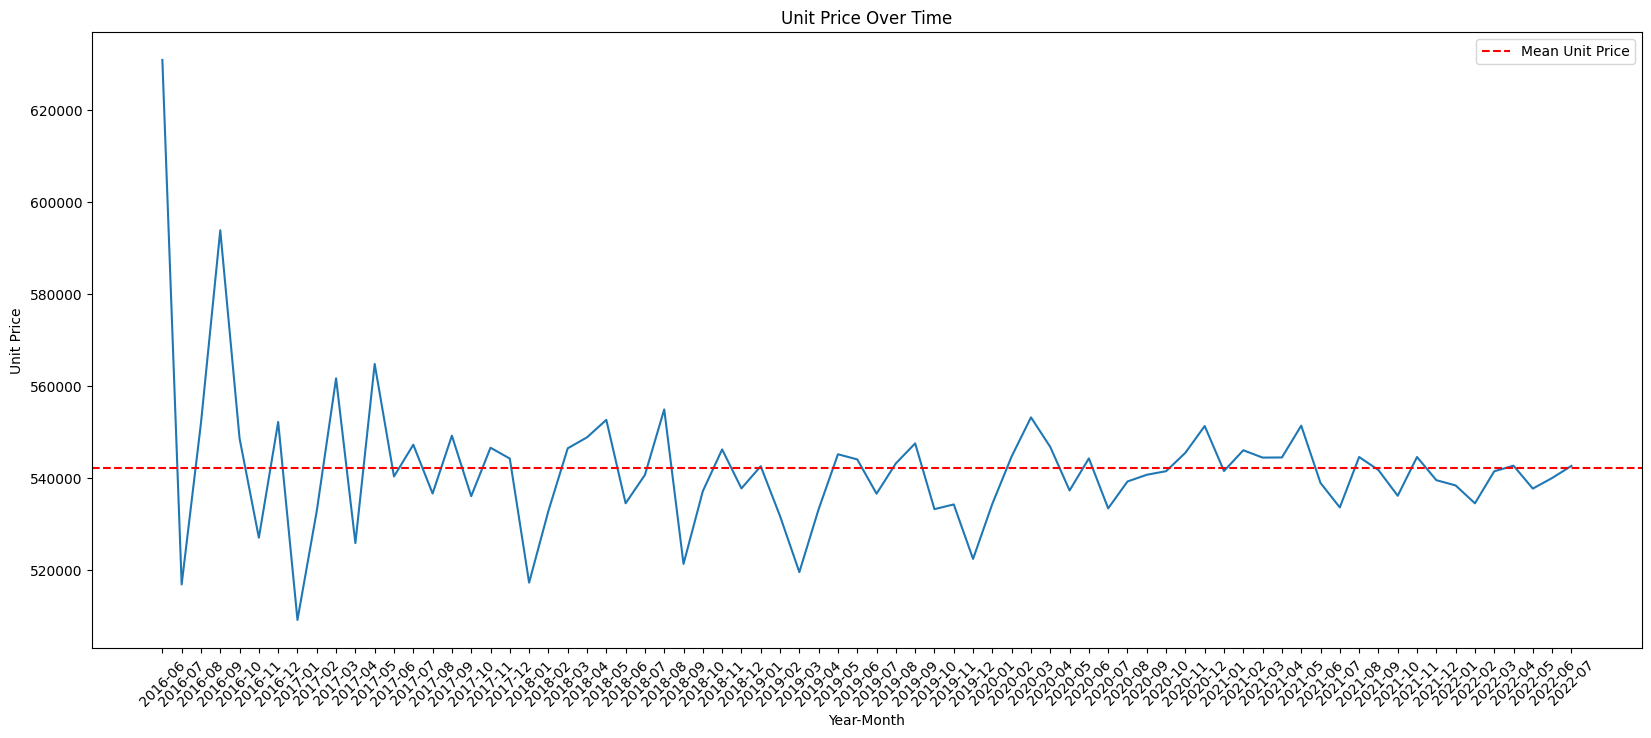

In [28]:
merged_unit['y_m'] = merged_unit['y_m'].astype(str)

# Plotting
plt.figure(figsize=(20, 8))

plt.plot(merged_unit['y_m'], merged_unit['unit_price'])

plt.xlabel('Year-Month')
plt.ylabel('Unit Price')
plt.title('Unit Price Over Time')

plt.xticks(rotation=45)

mean_unit_price = merged_unit['unit_price'].mean()
plt.axhline(mean_unit_price, color='red', linestyle='--', label='Mean Unit Price')

plt.legend(loc='upper right')

plt.show()

## 월별 고객군별 객단가

In [3]:
rfm = pd.read_csv('/content/drive/MyDrive/co_note/project/data/cust_seg_rfm.csv')
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customer_id      99999 non-null  int64  
 1   gender           99999 non-null  object 
 2   birthdate        99999 non-null  object 
 3   home_location    99999 non-null  object 
 4   first_join_date  99999 non-null  object 
 5   age_now          99999 non-null  int64  
 6   age_segment      99999 non-null  object 
 7   join_year        99999 non-null  int64  
 8   join_month       99999 non-null  int64  
 9   rfm_seg          50699 non-null  float64
dtypes: float64(1), int64(4), object(5)
memory usage: 7.6+ MB


In [4]:
rfm.dropna(subset=['rfm_seg'], inplace=True)

In [5]:
rfm.duplicated(subset=['customer_id']).sum()

0

In [6]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50699 entries, 2 to 99998
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customer_id      50699 non-null  int64  
 1   gender           50699 non-null  object 
 2   birthdate        50699 non-null  object 
 3   home_location    50699 non-null  object 
 4   first_join_date  50699 non-null  object 
 5   age_now          50699 non-null  int64  
 6   age_segment      50699 non-null  object 
 7   join_year        50699 non-null  int64  
 8   join_month       50699 non-null  int64  
 9   rfm_seg          50699 non-null  float64
dtypes: float64(1), int64(4), object(5)
memory usage: 4.3+ MB


In [14]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 852582 entries, 0 to 852581
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   customer_id      852582 non-null  int64              
 1   booking_id       852582 non-null  object             
 2   created_at       852582 non-null  datetime64[ns, UTC]
 3   total_amount     852582 non-null  int64              
 4   promo_amount     852582 non-null  int64              
 5   shipment_fee     852582 non-null  int64              
 6   sales            852582 non-null  int64              
 7   gender           852582 non-null  object             
 8   age_now          852582 non-null  int64              
 9   first_join_date  852582 non-null  object             
 10  y_m              852582 non-null  period[M]          
dtypes: datetime64[ns, UTC](1), int64(6), object(3), period[M](1)
memory usage: 71.6+ MB


In [15]:
sales.columns

Index(['customer_id', 'booking_id', 'created_at', 'total_amount',
       'promo_amount', 'shipment_fee', 'sales', 'gender', 'age_now',
       'first_join_date', 'y_m'],
      dtype='object')

In [16]:
rfm_1 = rfm[['customer_id','rfm_seg']]
sales_1 = sales[['customer_id','sales','y_m','booking_id']]

In [17]:
sales_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 852582 entries, 0 to 852581
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype    
---  ------       --------------   -----    
 0   customer_id  852582 non-null  int64    
 1   sales        852582 non-null  int64    
 2   y_m          852582 non-null  period[M]
 3   booking_id   852582 non-null  object   
dtypes: int64(2), object(1), period[M](1)
memory usage: 26.0+ MB


In [18]:
# segment별 객단가
# 322, 222, 122 그래프 각각 월별로 그려보기
rfm_sale = sales_1.merge(rfm_1, on='customer_id', how = 'left')
display(rfm_sale.info(), rfm_sale.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 852582 entries, 0 to 852581
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype    
---  ------       --------------   -----    
 0   customer_id  852582 non-null  int64    
 1   sales        852582 non-null  int64    
 2   y_m          852582 non-null  period[M]
 3   booking_id   852582 non-null  object   
 4   rfm_seg      852577 non-null  float64  
dtypes: float64(1), int64(2), object(1), period[M](1)
memory usage: 39.0+ MB


None

,customer_id,sales,y_m,booking_id,rfm_seg
0,3,170926,2020-05,0b3f17a4-f733-4eac-b9e9-37c039746e95,322.0
1,3,185699,2022-06,0fb5a9e6-f306-4c37-b7f0-992bc78064a7,322.0
2,3,287523,2021-07,1229bd35-7747-447a-a60b-02860bf7da7e,322.0
3,3,357560,2020-06,163e447d-f2c2-4fac-b8a1-015eb01afd41,322.0
4,3,195690,2021-01,182774df-3cde-46cf-b302-4d93e0d94288,322.0


In [20]:
session = pd.read_csv('/content/drive/MyDrive/co_note/project/data/buy_splt.csv')
session.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12463004 entries, 0 to 12463003
Data columns (total 14 columns):
 #   Column           Dtype  
---  ------           -----  
 0   session_id       object 
 1   event_name       object 
 2   event_time       object 
 3   traffic_source   object 
 4   product_id       float64
 5   quantity         int64  
 6   item_price       int64  
 7   payment_status   float64
 8   search_keywords  object 
 9   promo_code       float64
 10  promo_amount     int64  
 11  customer_id      float64
 12  booking_id       object 
 13  quarter          float64
dtypes: float64(5), int64(3), object(6)
memory usage: 1.3+ GB


In [21]:
session.columns

Index(['session_id', 'event_name', 'event_time', 'traffic_source',
       'product_id', 'quantity', 'item_price', 'payment_status',
       'search_keywords', 'promo_code', 'promo_amount', 'customer_id',
       'booking_id', 'quarter'],
      dtype='object')

In [22]:
session = session[['session_id','booking_id','event_name','event_time']]

In [23]:
session_for_unit = session.merge(rfm_sale, on='booking_id', how='left')

In [24]:
session_for_unit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12463004 entries, 0 to 12463003
Data columns (total 8 columns):
 #   Column       Dtype    
---  ------       -----    
 0   session_id   object   
 1   booking_id   object   
 2   event_name   object   
 3   event_time   object   
 4   customer_id  int64    
 5   sales        int64    
 6   y_m          period[M]
 7   rfm_seg      float64  
dtypes: float64(1), int64(2), object(4), period[M](1)
memory usage: 855.8+ MB


In [25]:
monthly_buy = session_for_unit[session.event_name == 'BOOKING']
monthly_buy.shape

(852582, 8)

In [26]:
monthly_buy['event_time'] = pd.to_datetime(monthly_buy['event_time'])
monthly_buy_cnt = monthly_buy.groupby(monthly_buy['event_time'].dt.to_period('M'))['session_id'].nunique()

<ipython-input-26-177174c8708d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_buy['event_time'] = pd.to_datetime(monthly_buy['event_time'])
<ipython-input-26-177174c8708d>:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly_buy_cnt = monthly_buy.groupby(monthly_buy['event_time'].dt.to_period('M'))['session_id'].nunique()


In [28]:
monthly_buy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 852582 entries, 5 to 12463003
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype              
---  ------       --------------   -----              
 0   session_id   852582 non-null  object             
 1   booking_id   852582 non-null  object             
 2   event_name   852582 non-null  object             
 3   event_time   852582 non-null  datetime64[ns, UTC]
 4   customer_id  852582 non-null  int64              
 5   sales        852582 non-null  int64              
 6   y_m          852582 non-null  period[M]          
 7   rfm_seg      852577 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(1), int64(2), object(3), period[M](1)
memory usage: 58.5+ MB


In [35]:
monthly_buy.rfm_seg.value_counts()

322.0    600286
222.0    162894
111.0     27871
211.0     22313
221.0     12352
311.0      8497
321.0      6567
122.0      4687
112.0      2806
212.0      2702
312.0      1048
121.0       554
Name: rfm_seg, dtype: int64

In [30]:
monthly_buy['event_time'] = pd.to_datetime(monthly_buy['event_time'])

# Change the datatype to monthly frequency
monthly_buy['event_time'] = monthly_buy['event_time'].dt.to_period('M')

<ipython-input-30-11e5b1c2aa16>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_buy['event_time'] = pd.to_datetime(monthly_buy['event_time'])
<ipython-input-30-11e5b1c2aa16>:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly_buy['event_time'] = monthly_buy['event_time'].dt.to_period('M')
<ipython-input-30-11e5b1c2aa16>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_buy['event_time'] = monthly_buy['event_time'].dt.to_period('M')


In [ ]:
# groupby(['event_time, rfm_seg'])

In [36]:
rfm_122 = monthly_buy[monthly_buy['rfm_seg'] == 122]
rfm_222 = monthly_buy[monthly_buy['rfm_seg'] == 222]
rfm_322 = monthly_buy[monthly_buy['rfm_seg'] == 322]

In [37]:
rfm_122.head()
rfm_122

,session_id,booking_id,event_name,event_time,customer_id,sales,y_m,rfm_seg
209,8594ec4c-b084-400a-9111-50352176a29d_0,8a6bc9e2-6534-443e-8c66-62e27f51eb4a,BOOKING,2016-11,650,246217,2016-11,122.0
247,af5a5e2b-a4f0-46df-9690-266ca7062b00_0,b467f899-00fe-4957-97f8-47865507cda3,BOOKING,2016-11,722,188051,2016-11,122.0
543,ae475783-a886-4adc-8195-0b416447afd1_0,67522506-f832-4a55-923d-4faba96abc42,BOOKING,2016-08,1308,201165,2016-08,122.0
1138,b7a92dc8-3261-415e-b565-31be354921a2_0,9ae5c284-106f-474e-9f00-1e5ff7aef5b5,BOOKING,2016-11,2354,1686650,2016-11,122.0
1873,5e1c3d85-e88f-49bc-a8a9-02a87072339b_0,6057008e-bd30-4765-96c6-60a616fe0d2e,BOOKING,2016-08,3437,399671,2016-08,122.0


In [43]:
pd.options.display.float_format = '{:.2f}'.format
per_cus_122_sales = rfm_122.groupby('y_m')['sales'].sum()
per_cus_122.head()
per_cus_122_cnt = rfm_122.groupby('y_m')['session_id'].nunique()
per_cus_122_cnt
per_cus_122 = per_cus_122_sales/per_cus_122_cnt
per_cus_122

y_m
2016-07   1489107.55
2016-08    729037.00
2016-09   1408797.97
2016-10    933079.53
2016-11    748797.74
             ...    
2021-09   1064554.08
2021-10    907442.96
2021-11   1041924.01
2021-12   1023601.27
2022-01    148692.00
Freq: M, Length: 67, dtype: float64

In [52]:
import plotly.graph_objects as go

# Convert Period objects to strings
per_cus_122.index = per_cus_122.index.astype(str)

# Create the line graph
fig = go.Figure(data=go.Scatter(x=per_cus_122.index, y=per_cus_122, mode='lines'))

# Set the title and axis labels
fig.update_layout(title='122 sales per unit',
                  xaxis_title='Year-Month',
                  yaxis_title='Sales per Customer')

# Display the line graph
fig.show()

In [47]:
pd.options.display.float_format = '{:.2f}'.format
per_cus_222_sales = rfm_222.groupby('y_m')['sales'].sum()
per_cus_222_cnt = rfm_222.groupby('y_m')['session_id'].nunique()
per_cus_222_cnt
per_cus_222 = per_cus_222_sales/per_cus_222_cnt
per_cus_222

y_m
2016-07   462178.81
2016-08   597140.19
2016-09   571081.68
2016-10   605652.77
2016-11   561107.67
             ...   
2022-02   614429.65
2022-03   619968.37
2022-04   593420.39
2022-05   563182.55
2022-06   544493.51
Freq: M, Length: 72, dtype: float64

In [53]:
import plotly.graph_objects as go

# Convert Period objects to strings
per_cus_222.index = per_cus_222.index.astype(str)

# Create the line graph
fig = go.Figure(data=go.Scatter(x=per_cus_222.index, y=per_cus_222, mode='lines'))

# Set the title and axis labels
fig.update_layout(title='222 sales per unit',
                  xaxis_title='Year-Month',
                  yaxis_title='Sales per Customer')

# Display the line graph
fig.show()

In [50]:
pd.options.display.float_format = '{:.2f}'.format
per_cus_322_sales = rfm_322.groupby('y_m')['sales'].sum()
per_cus_322_cnt = rfm_322.groupby('y_m')['session_id'].nunique()
per_cus_322_cnt
per_cus_322 = per_cus_322_sales/per_cus_322_cnt
per_cus_322

y_m
2016-07   461223.09
2016-08   620870.47
2016-09   581821.60
2016-10   513836.41
2016-11   483634.46
             ...   
2022-03   547132.38
2022-04   556176.22
2022-05   548940.00
2022-06   553642.59
2022-07   565397.14
Freq: M, Length: 73, dtype: float64

In [54]:
import plotly.graph_objects as go

# Convert Period objects to strings
per_cus_322.index = per_cus_322.index.astype(str)

# Create the line graph
fig = go.Figure(data=go.Scatter(x=per_cus_322.index, y=per_cus_322, mode='lines'))

# Set the title and axis labels
fig.update_layout(title='322 sales per unit',
                  xaxis_title='Year-Month',
                  yaxis_title='Sales per Customer')

# Display the line graph
fig.show()

In [27]:
per_cus_122 = rfm_122['sales'].sum()

,event_time,buy_cnt
0,2016-06,1
1,2016-07,296
2,2016-08,547
3,2016-09,717
4,2016-10,989
...,...,...
69,2022-03,28801
70,2022-04,29237
71,2022-05,30084
72,2022-06,28587


In [ ]:
monthly_buy = session[session.event_name == 'BOOKING']
monthly_buy.shape
# ---
monthly_buy['event_time'] = pd.to_datetime(monthly_buy['event_time'])
monthly_buy_cnt = monthly_buy.groupby(monthly_buy['event_time'].dt.to_period('M'))['session_id'].nunique()
# ---
monthly_buy_cnt_df = monthly_buy_cnt.to_frame(name='buy_cnt').reset_index()
monthly_buy_cnt_df

# ---
monthly_buy_cnt_df.rename(columns={'event_time': 'y_m'}, inplace=True)
monthly_buy_cnt_df.head()
# ---
merged_unit = monthly_buy_cnt_df.merge(monthly_sales_df, on='y_m')
merged_unit

# ---
pd.options.display.float_format = '{:.2f}'.format

merged_unit['unit_price'] = merged_unit.sales / merged_unit.buy_cnt
merged_unit

# ----
merged_unit['y_m'] = merged_unit['y_m'].astype(str)

# Plotting
plt.figure(figsize=(20, 8))

plt.plot(merged_unit['y_m'], merged_unit['unit_price'])

plt.xlabel('Year-Month')
plt.ylabel('Unit Price')
plt.title('Unit Price Over Time')

plt.xticks(rotation=45)

mean_unit_price = merged_unit['unit_price'].mean()
plt.axhline(mean_unit_price, color='red', linestyle='--', label='Mean Unit Price')

plt.legend(loc='upper right')

plt.show()

In [ ]:
session_for_unit.session.unique()여기

## 고객 수를 구하는 것은 객단가와 관련 없음

### 구매 고객 수 -> 객단가는 session 별로 구할 것, 고객 수는 객단가랑 관련 없음

In [ ]:
monthly_cust_cnt = sales.groupby('y_m')['customer_id'].nunique()
monthly_cust_cnt

sales[sales['created_at'] < '2017-01-01']['customer_id'].nunique()

In [ ]:
monthly_cust_cnt_df = monthly_cust_cnt.to_frame(name='cus_cnt').reset_index()
monthly_cust_cnt_df

In [ ]:
monthly_cust_cnt_df.info()

### 월별 매출 및 구매고객 수

In [ ]:
merged_unit = monthly_cust_cnt_df.merge(monthly_sales_df, on='y_m')
merged_unit

In [ ]:
pd.options.display.float_format = '{:.2f}'.format

merged_unit['unit_price'] = merged_unit.sales / merged_unit.cus_cnt
merged_unit

cus_cnt 줄고


In [ ]:
merged_unit['y_m'] = merged_unit['y_m'].astype(str)

# Plotting
plt.figure(figsize=(20, 8))

plt.plot(merged_unit['y_m'], merged_unit['unit_price'])

plt.xlabel('Year-Month')
plt.ylabel('Unit Price')
plt.title('Unit Price Over Time')

plt.xticks(rotation=45)
plt.axvline('2022-02', color='purple', linestyle='--', label='2022-02')
plt.axvline('2022-06', color='orange', linestyle='--', label='2022-06')
plt.legend(loc='upper right')

plt.show()

In [ ]:
sales.booking_id.duplicated().sum()

## 월별 booking_id unique values

In [ ]:
booking_cnt = sales.groupby('y_m')['booking_id'].nunique()
booking_cnt

In [ ]:
booking_cnt_df = booking_cnt.to_frame(name='booking_cnt').reset_index()
booking_cnt_df

In [ ]:
merged_unit = merged_unit.merge(booking_cnt_df, on='y_m')
merged_unit.tail(10)